<img src = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTOkFwIF09DEVcgunZk_3EPp6FMWcxx8AUDRA&usqp=CAU' height = '600px' width = '600px'>

## Objective: Main aim of this notebook is to generate face behind the mask using autoencoder.

## Import Necessary Libraries

In [1]:
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import numpy as np
import os
import re


## Load data
Here I am going to load only 2000 images each with mask and no mask. These images are converted to an array and are appended in empty array. Here I also have defind function to load data serially. 

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

mask_path = '../input/face-mask-lite-dataset/with_mask'
mask_array = []

image_path = '../input/face-mask-lite-dataset/without_mask'
img_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
mask_file = sorted_alphanumeric(os.listdir(mask_path))
for i in tqdm(mask_file):
    if i == 'with-mask-default-mask-seed2000.png':
        break
    else:    
        image = cv2.imread(mask_path + '/' + i,1)

          # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))

        # normalizing image 
        image = image.astype('float32') / 255.0

        #appending normal normal image    
        mask_array.append(img_to_array(image))

  
    
for i in tqdm(image_file):
 
    if i == 'seed2000.png':
        break
    
    else:
        image = cv2.imread(image_path + '/' + i,1)

        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))

        # normalizing image 
        image = image.astype('float32') / 255.0
        # appending normal sketch image
        img_array.append(img_to_array(image))

   
    

 20%|██        | 2000/10000 [01:59<07:57, 16.75it/s]


## Plot image pair

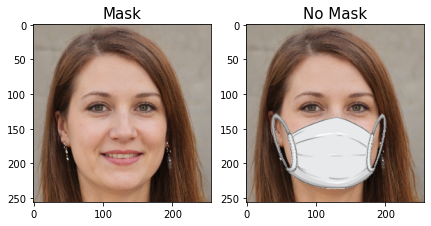

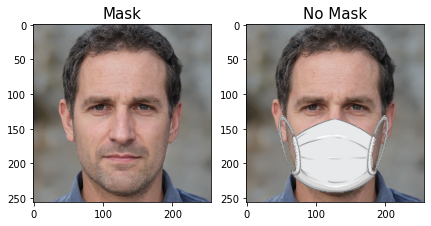

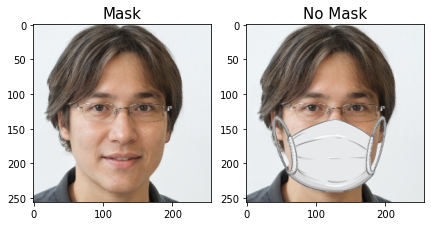

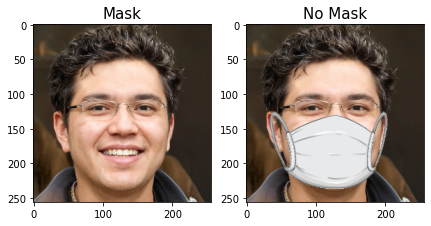

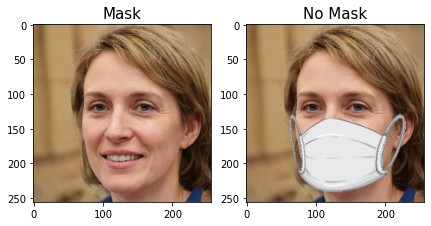

In [3]:
def plot_image_pair(images = 5):
    for i in range(images):
        plt.figure(figsize = (7,7))
        plt.subplot(1,2,1)
        plt.title("Mask", fontsize = 15)
        plt.imshow(img_array[i].reshape(SIZE, SIZE, 3))
        plt.subplot(1,2,2)
        plt.title("No Mask", fontsize = 15)
        plt.imshow(mask_array[i].reshape(SIZE, SIZE, 3))
        
        
        
plot_image_pair(5)
        
        

## Slicing and reshaping

In [4]:
train_mask_image = mask_array[:1800]
train_image = img_array[:1800]
test_mask_image = mask_array[1800:]
test_image = img_array[1800:]
# reshaping
train_mask_image = np.reshape(train_mask_image,(len(train_mask_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train no mask image shape:',train_image.shape)
test_mask_image = np.reshape(test_mask_image,(len(test_mask_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test no mask image shape',test_image.shape)

Train no mask image shape: (1800, 256, 256, 3)
Test no mask image shape (200, 256, 256, 3)


## Defining our model

In [5]:
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="img")
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = MaxPool2D(pool_size = (2,2))(x)

x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid')(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
x = MaxPool2D(pool_size = (2,2))(x)

x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder = tf.keras.Model(encoder_input, encoder_output)

decoder_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
x = UpSampling2D(size = (2,2))(decoder_input)
x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 164, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)

x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
 
x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
decoder_output = Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

# final model
model = keras.Model(encoder_input, decoder_output)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

## Compiling our model

In [6]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_mask_image, train_image, epochs = 150)

Epoch 1/150
57/57 [==============================] - 7s 131ms/step - loss: 0.3441 - acc: 0.5463
Epoch 2/150
57/57 [==============================] - 7s 122ms/step - loss: 0.1455 - acc: 0.8494
Epoch 3/150
57/57 [==============================] - 7s 121ms/step - loss: 0.1001 - acc: 0.8617
Epoch 4/150
57/57 [==============================] - 7s 123ms/step - loss: 0.0817 - acc: 0.8650
Epoch 5/150
57/57 [==============================] - 7s 122ms/step - loss: 0.0742 - acc: 0.8623
Epoch 6/150
57/57 [==============================] - 7s 124ms/step - loss: 0.0726 - acc: 0.8602
Epoch 7/150
57/57 [==============================] - 7s 120ms/step - loss: 0.0641 - acc: 0.8593
Epoch 8/150
57/57 [==============================] - 7s 121ms/step - loss: 0.0610 - acc: 0.8582
Epoch 9/150
57/57 [==============================] - 7s 121ms/step - loss: 0.0603 - acc: 0.8590
Epoch 10/150
57/57 [==============================] - 7s 121ms/step - loss: 0.0577 - acc: 0.8675
Epoch 11/150
57/57 [===================

57/57 [==============================] - 7s 123ms/step - loss: 0.0354 - acc: 0.9253
Epoch 86/150
57/57 [==============================] - 7s 120ms/step - loss: 0.0355 - acc: 0.9226
Epoch 87/150
57/57 [==============================] - 7s 122ms/step - loss: 0.0360 - acc: 0.9258
Epoch 88/150
57/57 [==============================] - 7s 119ms/step - loss: 0.0349 - acc: 0.9249
Epoch 89/150
57/57 [==============================] - 7s 119ms/step - loss: 0.0356 - acc: 0.9242
Epoch 90/150
57/57 [==============================] - 7s 126ms/step - loss: 0.0368 - acc: 0.9228
Epoch 91/150
57/57 [==============================] - 7s 120ms/step - loss: 0.0355 - acc: 0.9222
Epoch 92/150
57/57 [==============================] - 7s 119ms/step - loss: 0.0343 - acc: 0.9235
Epoch 93/150
57/57 [==============================] - 7s 119ms/step - loss: 0.0336 - acc: 0.9300
Epoch 94/150
57/57 [==============================] - 7s 119ms/step - loss: 0.0342 - acc: 0.9246
Epoch 95/150
57/57 [=======================

## Model evaluation

In [10]:
loss_acc= model.evaluate(test_mask_image, test_image)
print("Loss: ",loss_acc[0])
print('Accuracy: ', np.round(loss_acc[1],2) * 100)

7/7 [==============================] - 0s 40ms/step - loss: 0.0350 - acc: 0.9314
Loss:  0.034952715039253235
Accuracy:  93.0


## plotting images

In [11]:
def plot_images(start = 0, end = 5):
    for i in range(start, end, 1):
        plt.figure(figsize = (10,10))
        plt.subplot(1,3,1)
        plt.title("No Mask", fontsize = 12)
        plt.imshow(test_image[i])
        plt.subplot(1,3,2)
        plt.title("Mask", fontsize = 12)
        plt.imshow(test_mask_image[i])
        plt.subplot(1,3,3)
        plt.title("Predicted", fontsize = 12)
        prediction = model.predict(test_mask_image[i].reshape(1,SIZE, SIZE, 3)).reshape(SIZE, SIZE, 3)
        plt.imshow(prediction)
        plt.show()
        

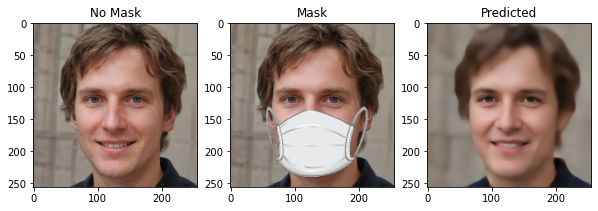

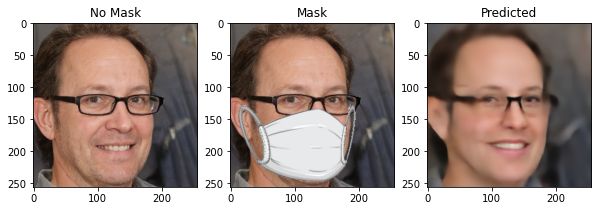

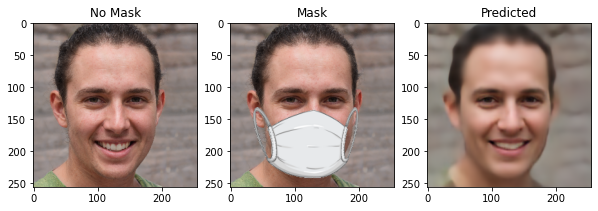

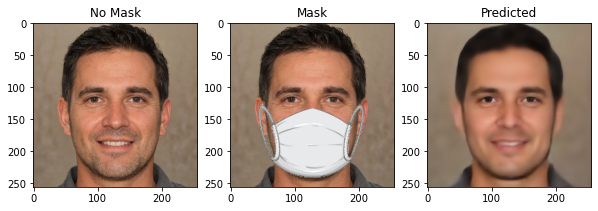

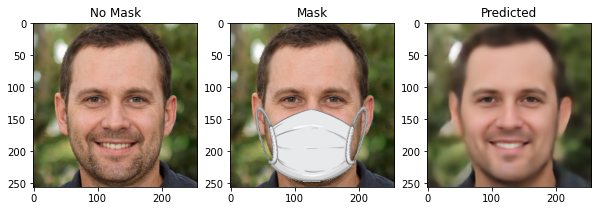

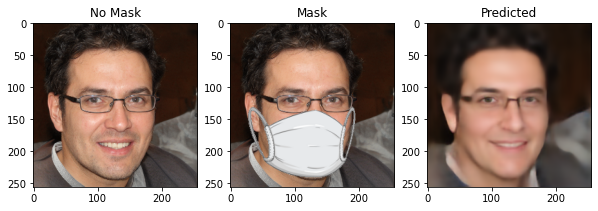

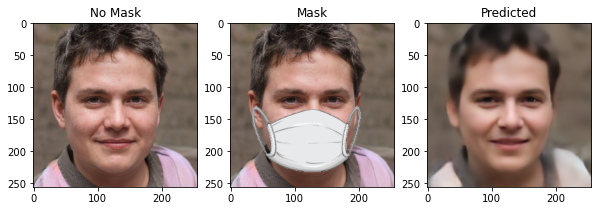

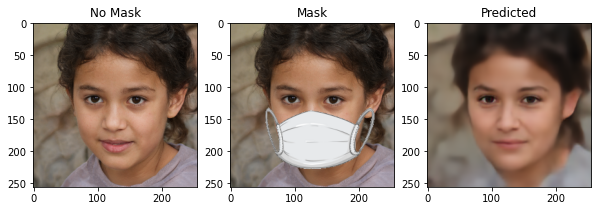

In [14]:
plot_images(27,35)

# Thanks for your visit